In [1]:
import os
os.chdir('..')

import networkx as nx
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

import persim # see persim.scikit-tda.org
from ripser import ripser # see ripser.scikit-tda.org

To generate the model used in this example, I ran:

`python main.py --arch_type lenet5_nmp --dataset cifar10 --prune_percent 90 --prune_iterations 2 --end_iter 50`

In [2]:
# Global-like variable definitions.
model_name = 'lenet5_nmp'
dataset_name = 'cifar10'
data_location = '../data' # location of training data (MNIST, FashionMNIST, CIFAR, etc.)
msk_pct = 90 # prune percentage for LT network
model_loc0 = 'saves/{}/{}/0_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, un-pruned model 
model_loc1 = 'saves/{}/{}/1_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, pruned model (after 1 prune iteration)

## Unpruned Model Homology

In [3]:
# load the model.
model = torch.load(model_loc0)

In [4]:
# access model params and add to list `params`. We are ignoring bias weights for now.
params = []
for name, param in model.named_parameters():
    if 'weight' in name:
        pnum = param.data.cpu().numpy()
        print('Parameter Shape: ', pnum.shape)
        params.append(pnum)

Parameter Shape:  (6, 3, 5, 5)
Parameter Shape:  (16, 6, 5, 5)
Parameter Shape:  (120, 9216)
Parameter Shape:  (84, 120)
Parameter Shape:  (10, 84)


In [7]:
input_size = (1,3,32,32)

In [170]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * padding - field_height) % stride == 0
    assert (W + 2 * padding - field_height) % stride == 0
    out_height = int((H + 2 * padding - field_height) / stride + 1)
    out_width = int((W + 2 * padding - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k.astype(int), i.astype(int), j.astype(int))

def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols

def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1,
                   stride=1):
    """ An implementation of col2im based on fancy indexing and np.add.at """
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

def conv_layer_as_matrix(X, X_names, W, stride, padding):
    n_filters, d_filter, h_filter, w_filter = W.shape
    n_x, d_x, h_x, w_x = X.shape
    h_out = (h_x - h_filter + 2 * padding) / stride + 1
    w_out = (w_x - w_filter + 2 * padding) / stride + 1
    
    X_col = im2col_indices(X, h_filter, w_filter, padding=padding, stride=stride)
    X_names_col = im2col_indices(X_names, h_filter, w_filter, padding=padding, stride=stride)
    W_col = W.reshape(n_filters, -1)
    
    out = W_col @ X_col
    out = out.reshape(n_filters, int(h_out), int(w_out), n_x)
    out = out.transpose(3, 0, 1, 2)
    
    return out, X_col, W_col, X_names_col

def conv_to_directed_networkx(params, input_size, layer_names=None, stride=1, padding=0):
    # store all network info here
    G = nx.DiGraph()
    
    # create layer names as integers if not provided by user
    if layer_names is None:
        layer_names = [i for i in range(len(params)+1)]
    
    # formatting for node names (layer, channel, node)
    conv_format = '{}_{}_{}'
    
    # need to look ahead at next layer to get naming correct
    # assume last layer linear    
    for l in range(len(params)-1):
        print('Layer: {}'.format(l))
        p = params[l]
        pnext = params[l+1]
        if len(p.shape) == 4:
            # convolutional layer
            input_channels = p.shape[1]
            if len(pnext.shape) == 4:
                # next layer also conv
                X = np.ones(input_size)
                for c in range(input_channels):
                    print('Channel: {}'.format(c))
                    X_names = np.arange(X.shape[2]*X.shape[3]).reshape((1,1,X.shape[2],X.shape[3]))
                    tx = X[:,c,:,:].reshape((X.shape[0],1,X.shape[2],X.shape[3]))
                    # convert to matrix information
                    mat, X_col, W_col, xnames = conv_layer_as_matrix(tx,X_names,p[:,c,:,:].reshape((p.shape[0],1,p.shape[2],p.shape[3])),stride,padding)
                    x2names = np.arange(X_col.shape[1])
                    for f in range(W_col.shape[0]):
                        for row in range(X_col.shape[0]):
                            for col in range(X_col.shape[1]):
                                v = W_col[f,row]
                                if v != 0:
                                    G.add_edge(conv_format.format(layer_names[l],c,xnames[row,col]),conv_format.format(layer_names[l+1],f,col), weight=np.abs(1/v))
                input_size = mat.shape
                
            elif len(pnext.shape) == 2:
                # next layer linear
                X = np.ones(input_size)
                for c in range(input_channels):
                    print('Channel: {}'.format(c))
                    X_names = np.arange(X.shape[2]*X.shape[3]).reshape((1,1,X.shape[2],X.shape[3]))
                    tx = X[:,c,:,:].reshape((X.shape[0],1,X.shape[2],X.shape[3]))
                    # convert to matrix information
                    mat, X_col, W_col, xnames = conv_layer_as_matrix(tx,X_names,p[:,c,:,:].reshape((p.shape[0],1,p.shape[2],p.shape[3])),stride,padding)
                    x2names = np.arange(X_col.shape[1])
                    for f in range(W_col.shape[0]):
                        for row in range(X_col.shape[0]):
                            for col in range(X_col.shape[1]):
                                v = W_col[f,row]
                                if v != 0:
                                    G.add_edge(conv_format.format(layer_names[l],c,xnames[row,col]),conv_format.format(layer_names[l+1],0,col), weight=np.abs(1/v))
                input_size = mat.shape
        elif len(p.shape) == 2:
            # linear layer
            for row in range(p.shape[1]):
                for col in range(p.shape[0]):
                    v = p[col,row]
                    if v != 0:
                        G.add_edge(conv_format.format(layer_names[l],0,row),conv_format.format(layer_names[l+1],0,col), weight=np.abs(1/v))
        else:
            raise ValueError('Layer type not implemented ')
            
    # add in last layer
    p = params[-1]
    for row in range(p.shape[1]):
        for col in range(p.shape[0]):
            v = p[col,row]
            if v != 0:
                G.add_edge(conv_format.format(layer_names[-2],0,row),conv_format.format(layer_names[-1],0,col), weight=np.abs(1/v))

    return G


# helper function for testing model, outputs accuracy
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [171]:
G = conv_to_directed_networkx(params, input_size)

Layer: 0
Channel: 0
Channel: 1
Channel: 2
Layer: 1
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Layer: 2
Layer: 3


In [172]:
G.edges[('2_0_1244', '3_0_114')]

{'weight': 8.107979848355166e+39}

In [173]:
# Test to make sure model works.
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
testdataset = datasets.CIFAR10(data_location, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=0,drop_last=True)
criterion = torch.nn.CrossEntropyLoss()
print('Accuracy: {}'.format(test(model, test_loader, criterion)))

Accuracy: 49.85


In [174]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
rips = ripser(nx.to_scipy_sparse_matrix(G), distance_matrix=True, maxdim=1)
rips

{'dgms': [array([[0.       , 0.5416193],
         [0.       , 0.5416193],
         [0.       , 0.5416193],
         ...,
         [0.       ,       inf],
         [0.       ,       inf],
         [0.       ,       inf]]),
  array([[      inf,       inf],
         [      inf,       inf],
         [      inf,       inf],
         ...,
         [0.6291101,       inf],
         [0.6291101,       inf],
         [0.6291101,       inf]])],
 'cocycles': [[], []],
 'num_edges': 265224,
 'dperm2all': <17206x17206 sparse matrix of type '<class 'numpy.float64'>'
 	with 1556036 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([    0,     1,     2, ..., 17203, 17204, 17205]),
 'r_cover': 0.0}

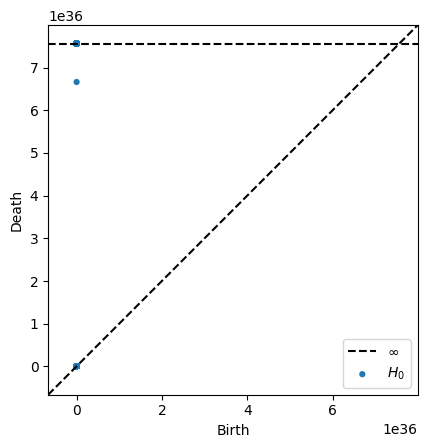

In [175]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips['dgms'][0])

## Pruned LT Homology

In [176]:
# load the LT model.
model_lt = torch.load(model_loc1)

In [177]:
# access model params and add to list `params`. We are ignoring bias weights for now.
params_lt = []
for name, param in model_lt.named_parameters():
    if 'weight' in name:
        pnum = param.data.cpu().numpy()
        print('Parameter Shape: ', pnum.shape)
        params_lt.append(pnum)

Parameter Shape:  (6, 3, 5, 5)
Parameter Shape:  (16, 6, 5, 5)
Parameter Shape:  (120, 9216)
Parameter Shape:  (84, 120)
Parameter Shape:  (10, 84)


In [178]:
# test this model's accuracy.
print('Accuracy: {}'.format(test(model_lt, test_loader, criterion)))

Accuracy: 38.39


In [180]:
# compute networkx representation of LT NN.
G_lt = conv_to_directed_networkx(params_lt, input_size)

Layer: 0
Channel: 0
Channel: 1
Channel: 2
Layer: 1
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Layer: 2
Layer: 3


In [181]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
rips_lt = ripser(nx.to_scipy_sparse_matrix(G_lt), distance_matrix=True, maxdim=1)
rips_lt

{'dgms': [array([[0.        , 0.59854257],
         [0.        , 0.6207661 ],
         [0.        , 0.63897318],
         ...,
         [0.        ,        inf],
         [0.        ,        inf],
         [0.        ,        inf]]),
  array([[       inf,        inf],
         [       inf,        inf],
         [       inf,        inf],
         ...,
         [1.98528039,        inf],
         [1.90895331,        inf],
         [1.46641684,        inf]])],
 'cocycles': [[], []],
 'num_edges': 46734,
 'dperm2all': <17048x17048 sparse matrix of type '<class 'numpy.float64'>'
 	with 220693 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([    0,     1,     2, ..., 17045, 17046, 17047]),
 'r_cover': 0.0}

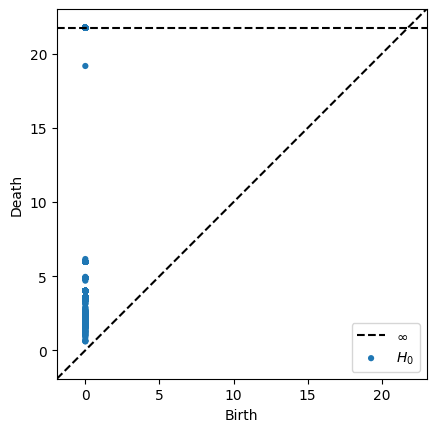

In [186]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips_lt['dgms'][0])

## Compare Networks

/home/schraterlab/gebhart/projects/LTH-Topology/env/lib/python3.6/site-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "ignoring those points"
/home/schraterlab/gebhart/projects/LTH-Topology/env/lib/python3.6/site-packages/persim/bottleneck.py:65: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "ignoring those points"


Bottleneck Distance: 3.3316446950348835e+36


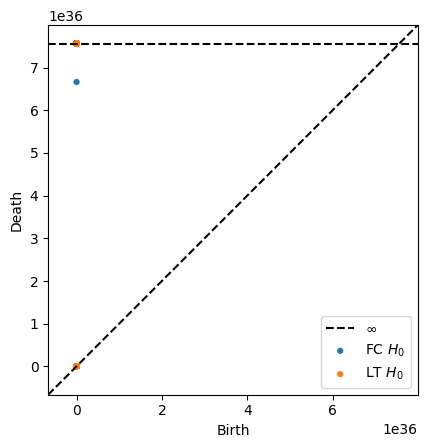

In [184]:
# compute the bottleneck distance between networks and plot the implicit matching. 
# bottleneck distance is defined as the distance between the farthest-apart matched points. 
# NOTE: the persim package ignores points at infinity, so this calculation still returns 
# a bounded result. Technically, the bottleneck distance between the two networks is \infty. 
distance_bottleneck, (matching, D) = persim.bottleneck(rips['dgms'][0], rips_lt['dgms'][0], matching=True)
persim.bottleneck_matching(rips['dgms'][0], rips_lt['dgms'][0], matching, D, labels=['FC $H_0$', 'LT $H_0$'])
print('Bottleneck Distance: {}'.format(distance_bottleneck))